Load the Data 

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the data
directory = '/Users/Erfan/Desktop/BISC_Data'
file_name = 'matched_data.npz'
output_path = f"{directory}/{file_name}"
downsample = True

data = np.load(output_path)
Y_matched = data['Y_matched']  # Shape: [1008, 1000, 401]
Z_matched = data['Z_matched']  # Shape: [1008, 1000, 401]
locations_matched = data['locations_matched']  # Shape: [401, 1000, 2]

# Combine Y and Z (vector field data)
wave_data = np.stack((Y_matched, Z_matched), axis=-1)  # Shape: [1008, 1000, 401, 2]
wave_data = np.transpose(wave_data, (2, 1, 0, 3))  # Shape: [401, 1000, 1008, 2]

# Downsample the data
if downsample:
    wave_data = wave_data[:, :wave_data.shape[1] - (wave_data.shape[1] % 25), :, :].reshape(
        wave_data.shape[0], -1, 25, wave_data.shape[2], wave_data.shape[3]
    ).mean(axis=2)
    locations_matched = locations_matched[:, ::25, :]  # Downsample locations

# wave_data.shape
# wave_data = wave_data[0:50, :, :,:]
wave_data.shape


(401, 40, 1008, 2)

In [3]:

import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the data
directory = '/Users/Erfan/Desktop/BISC_Data'
file_name = 'matched_data.npz'
output_path = f"{directory}/{file_name}"
downsample = True

data = np.load(output_path)
Y_matched = data['Y_matched']  # Shape: [1008, 1000, 401]
Z_matched = data['Z_matched']  # Shape: [1008, 1000, 401]
locations_matched = data['locations_matched']  # Shape: [401, 1000, 2]


wave_data = np.stack((Y_matched, Z_matched), axis=-1)  # Shape: [1008, 1000, 401, 2]
wave_data = np.transpose(wave_data, (2, 1, 0, 3))  # Shape: [401, 1000, 1008, 2]

# Downsample the data
if downsample:
    wave_data = wave_data[:, :wave_data.shape[1] - (wave_data.shape[1] % 25), :, :].reshape(
        wave_data.shape[0], -1, 25, wave_data.shape[2], wave_data.shape[3]
    ).mean(axis=2)
    locations_matched = locations_matched[:, ::25, :]  # Downsample locations
###############################################################################
# PADDING LOGIC: from 1008 channels to 1024 channels
###############################################################################
current_shape = wave_data.shape  # e.g., (401, 40, 1008, 2)
desired_num_channels = 1024      # We want 32x32 = 1024

padded_shape = (
    current_shape[0],             # e.g. 401
    current_shape[1],             # e.g. 40
    desired_num_channels,         # 1024
    current_shape[3]              # e.g. 2
)
wave_data_padded = np.zeros(padded_shape, dtype=wave_data.dtype)


# Place the original 1008 channels in the middle, from index 8 to 8+1008=1016
wave_data_padded[..., 8:8+current_shape[2], :] = wave_data
# So channels 0..7 and 1016..1023 remain zero => "dead"

# Overwrite wave_data with the padded version
wave_data = wave_data_padded
print("New padded wave_data shape:", wave_data.shape)


New padded wave_data shape: (401, 40, 1024, 2)


Single Example

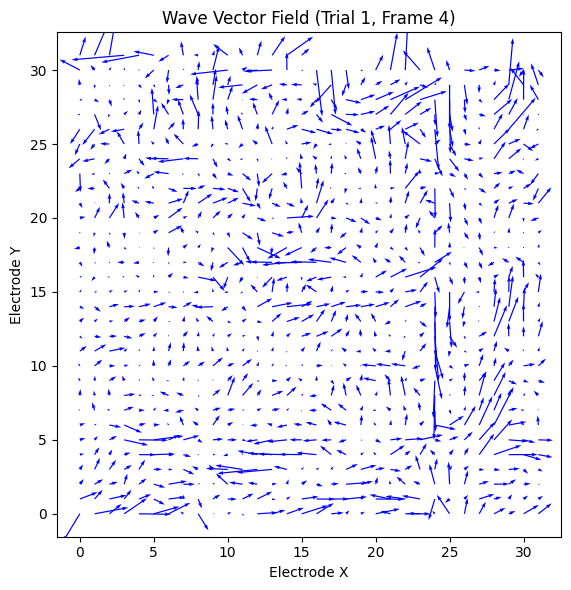

In [102]:

# Visualize the vector field
trial_idx = 1  # sample trial index
frame_idx = 4  # sample frame index
trial_Y = wave_data[trial_idx, frame_idx, :, 0] 
trial_Z = wave_data[trial_idx, frame_idx, :, 1]  
num_electrodes = wave_data.shape[2] 
grid_dim = int(np.ceil(np.sqrt(num_electrodes)))
x_grid, y_grid = np.meshgrid(np.arange(grid_dim), np.arange(grid_dim))
elec_pos = np.column_stack((x_grid.ravel(), y_grid.ravel()))[:num_electrodes]
fig, ax_wave = plt.subplots(figsize=(6, 6))
# ax_wave.set_xlim(0, grid_dim)
# ax_wave.set_ylim(0, grid_dim)
ax_wave.set_aspect('equal')
ax_wave.set_facecolor("white")
ax_wave.set_title(f"Wave Vector Field (Trial {trial_idx}, Frame {frame_idx})")
ax_wave.set_xlabel("Electrode X")
ax_wave.set_ylabel("Electrode Y")

quiver = ax_wave.quiver(
    elec_pos[:, 0], elec_pos[:, 1],
    trial_Y, trial_Z,
    color='blue', scale=1
)

plt.tight_layout()
plt.show()


Subsampling

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

##############################################################################
# 1) Subsampling function
##############################################################################
def subsample_electrodes(trial_data, factor):
    """
    Subsample electrodes by summing neighboring electrodes.
    Args:
        trial_data (ndarray): Shape [T, num_electrodes, 2]
                              (T can be number of time frames or any first dimension)
        factor (int): Subsampling factor (e.g., 4 for 1/4 resolution)
    Returns:
        ndarray: Subsampled data [T, new_num_electrodes, 2]
    """
    num_electrodes = trial_data.shape[1]
    new_num_electrodes = num_electrodes // factor
    trimmed_data = trial_data[:, : new_num_electrodes * factor] 
    subsampled_data = trimmed_data.reshape(
        trial_data.shape[0], new_num_electrodes, factor, 2
    ).sum(axis=2)
    return subsampled_data

UMAP visualization of wave patterns across conditions

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages

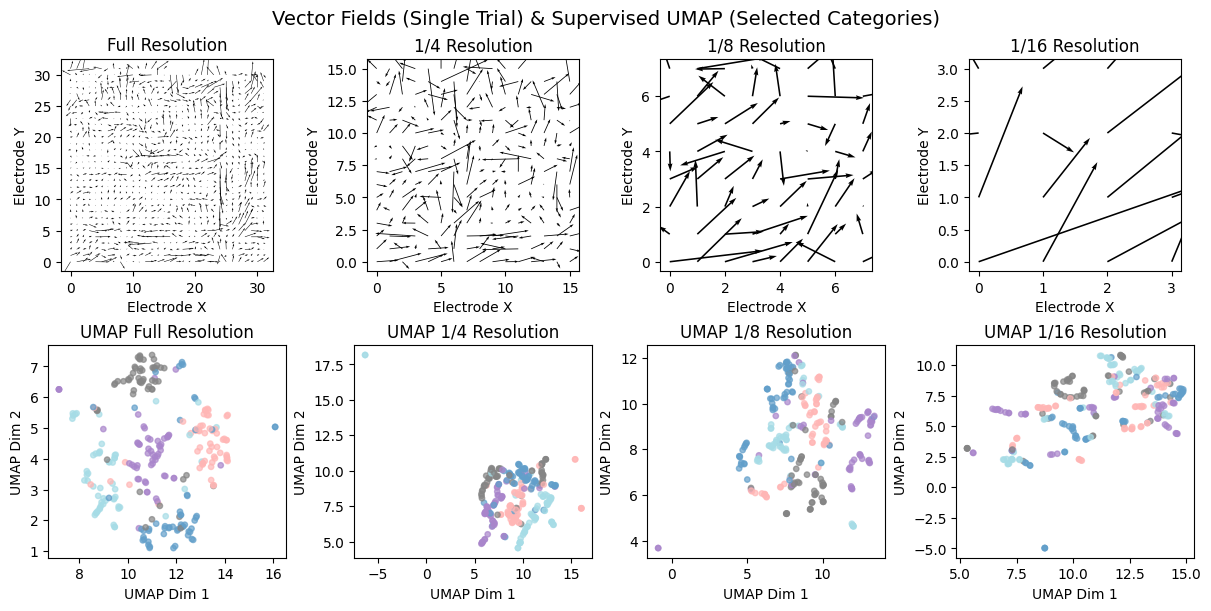

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

##############################################################################
# 1) Subsampling function
##############################################################################
def subsample_electrodes(trial_data, factor):
    """
    Subsample electrodes by summing neighboring electrodes.
    Args:
        trial_data (ndarray): Shape [T, num_electrodes, 2]
                              (T can be number of time frames or any first dimension)
        factor (int): Subsampling factor (e.g., 4 for 1/4 resolution)
    Returns:
        ndarray: Subsampled data [T, new_num_electrodes, 2]
    """
    num_electrodes = trial_data.shape[1]
    new_num_electrodes = num_electrodes // factor
    # Trim to make it divisible by 'factor'
    trimmed_data = trial_data[:, : new_num_electrodes * factor]
    # Reshape and sum
    subsampled_data = trimmed_data.reshape(
        trial_data.shape[0], new_num_electrodes, factor, 2
    ).sum(axis=2)
    return subsampled_data

##############################################################################
# 2) Predefined Colors
##############################################################################
def get_label_colors(labels):
    """
    Map each label to a predefined color.
    Args:
        labels (ndarray): Array of labels.
    Returns:
        list: List of colors corresponding to the labels.
    """
    # Define a color dictionary for predefined colors
    label_color_map = {
        24: "#629fca",  # Red
        39: "#ffb6b5ff",  # Green
        40: "#a985cbff",  # Blue
        # 1: "#FFA500",  # Orange
        90: "#858585ff",  # Purple
        53: "#a6dce6ff",  # Purple
    }
    return [label_color_map[label] for label in labels]

##############################################################################
# 3) Main Analysis and Visualization
##############################################################################
n_trials = 401
selected_categories = [24, 39, 40,53,90]

# Suppose wave_data has shape [nTotalTrials, 1000, 1008, 2]
# Replace wave_data and categories with your actual data
# wave_data = np.random.randn(500, 1000, 1008, 2)  # Placeholder for wave data
# categories = np.random.choice([24, 39, 40, 53, 90], size=(500, 1000))  # Placeholder for categories
# stimulus_labels = np.random.choice([0, 255], size=(401, 40))  # Placeholder for stimulus labels

wave_data_n = wave_data[:n_trials]  # shape => (n_trials, 1000, 1008, 2)
labels_n = categories[:n_trials].reshape(-1)  # Flatten to (n_trials*1000,)

# Filter stimulus labels
stimulus_labels_flat = stimulus_labels.flatten()  # Flatten to (n_trials*frames,)
stimulus_mask = (stimulus_labels_flat == 0)  # Keep only frames where stimulus_label == 0

# Apply the mask to filter wave_data_n and labels_n
wave_data_n_filtered = wave_data_n.reshape(-1, wave_data_n.shape[2], wave_data_n.shape[3])[stimulus_mask]
labels_n_filtered = labels_n[stimulus_mask]

# Reshape wave_data to align with labels
wave_data_n_reshaped = wave_data_n_filtered  # Already filtered
mask = np.isin(labels_n_filtered, selected_categories)  # Mask for selected categories
filtered_data = wave_data_n_reshaped[mask]  # Select rows matching the mask
filtered_labels = labels_n_filtered[mask]  # Filter labels

# Visualize the results across multiple resolutions
resolutions = [1, 4, 16, 64]
titles = ["Full Resolution", "1/4 Resolution", "1/8 Resolution", "1/16 Resolution"]

fig, axes = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)

# We keep the same frame & single trial for the quiver plot
plot_trial_idx = 1
plot_frame_idx = 4

plot_trial_data = wave_data[plot_trial_idx]  # Extract single trial for quiver plot

for i, factor in enumerate(resolutions):
    # Subsample the single trial data for the quiver plot
    if factor > 1:
        plot_trial_data_sub = subsample_electrodes(plot_trial_data, factor)
    else:
        plot_trial_data_sub = plot_trial_data  # No subsampling

    trial_Y = plot_trial_data_sub[plot_frame_idx, :, 0]
    trial_Z = plot_trial_data_sub[plot_frame_idx, :, 1]
    num_electrodes_sub = plot_trial_data_sub.shape[1]
    grid_dim = int(np.ceil(np.sqrt(num_electrodes_sub)))
    x_grid, y_grid = np.meshgrid(np.arange(grid_dim), np.arange(grid_dim))
    elec_pos = np.column_stack((x_grid.ravel(), y_grid.ravel()))[:num_electrodes_sub]

    # Quiver subplot (top row)
    ax_quiver = axes[0, i]
    ax_quiver.set_aspect("equal")
    ax_quiver.set_title(titles[i])
    ax_quiver.set_xlabel("Electrode X")
    ax_quiver.set_ylabel("Electrode Y")
    ax_quiver.quiver(
        elec_pos[:, 0], elec_pos[:, 1],
        trial_Y, trial_Z,
        color="black", scale=1
    )

    # Subsample the filtered data for UMAP
    if factor > 1:
        filtered_data_sub = subsample_electrodes(filtered_data, factor)
    else:
        filtered_data_sub = filtered_data  # No subsampling

    # Flatten data for UMAP
    filtered_data_sub = np.sqrt(filtered_data_sub[:, :, 1]**2 + filtered_data_sub[:, :, 0]**2)
    flattened_data = filtered_data_sub.reshape(filtered_data_sub.shape[0], -1)

    # Run supervised UMAP
    umap_model = umap.UMAP(n_neighbors=8, min_dist=0.01, n_components=2, random_state=42)
    umap_results = umap_model.fit_transform(flattened_data, y=filtered_labels)

    # Get colors for labels
    label_colors = get_label_colors(filtered_labels)

    # Plot UMAP (bottom row)
    ax_umap = axes[1, i]
    scatter = ax_umap.scatter(
        umap_results[:, 0], umap_results[:, 1],
        c=label_colors,        # Use predefined colors
        s=15,
        alpha=0.7
    )
    ax_umap.set_title("UMAP " + titles[i])
    ax_umap.set_xlabel("UMAP Dim 1")
    ax_umap.set_ylabel("UMAP Dim 2")

# # Add a legend for the predefined colors
# legend_labels = list(get_label_colors(selected_categories))
# legend_patches = [plt.Line2D([0], [0], marker='o', color=color, linestyle='') for color in legend_labels]
# plt.legend(
#     legend_patches, selected_categories,
#     title="Categories",
#     loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=len(selected_categories)
# )

plt.suptitle("Vector Fields (Single Trial) & Supervised UMAP (Selected Categories)", fontsize=14)
plt.show()


Clustering Quality Check

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples
import umap

# Example resolutions and data
resolutions = [1, 4, 16, 64]
silhouette_scores = []

for factor in resolutions:
    # Subsample the data for UMAP
    if factor > 1:
        filtered_data_sub = subsample_electrodes(filtered_data, factor)
    else:
        filtered_data_sub = filtered_data  # No subsampling

    # Flatten data for UMAP
    filtered_data_sub = np.sqrt(filtered_data_sub[:, :, 1]**2 + filtered_data_sub[:, :, 0]**2)
    flattened_data = filtered_data_sub.reshape(filtered_data_sub.shape[0], -1)

    # Run supervised UMAP
    umap_model = umap.UMAP(n_neighbors=8, min_dist=0.01, n_components=2, random_state=42)
    umap_results = umap_model.fit_transform(flattened_data, y=filtered_labels)

    # Calculate Silhouette Scores for all samples
    scores = silhouette_samples(umap_results, filtered_labels)
    silhouette_scores.append(scores)

# Create the box plot
plt.figure(figsize=(3, 6))

plt.boxplot(
    silhouette_scores,
    patch_artist=True,
    widths=0.6,
    showfliers=False,  # Do not show outliers
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1)
)

# Add red dots for the mean values
means = [np.mean(scores) for scores in silhouette_scores]
plt.plot(range(1, len(resolutions) + 1), means, 'o', color='darkred', label='Mean')

# Label axes and title
plt.xticks(range(1, len(resolutions) + 1), resolutions)
plt.xlabel("Resolution")
plt.ylabel("Score")
plt.title("Clustering Quality (Silhouette)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


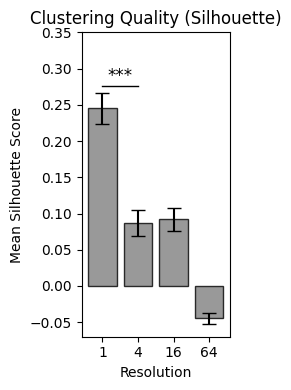

In [404]:
from scipy.stats import sem
from scipy.stats import ttest_ind

# Calculate the mean and SEM for the silhouette scores
means = [np.mean(scores) for scores in silhouette_scores]
sems = [sem(scores) for scores in silhouette_scores]

# Create a bar plot with SEM as error bars
plt.figure(figsize=(2.5, 4))
plt.bar(
    range(len(resolutions)), 
    means, 
    yerr=sems, 
    color='gray', 
    alpha=0.8, 
    edgecolor='black', 
    capsize=5
)

# Perform t-tests for the specified comparisons
stat_1_vs_2, p_1_vs_2 = ttest_ind(silhouette_scores[0], silhouette_scores[1], equal_var=False)
stat_1_vs_last, p_1_vs_last = ttest_ind(silhouette_scores[0], silhouette_scores[-1], equal_var=False)

# Set significance levels for stars
def significance_stars(p_value):
    if p_value < 0.0001:
        return "***"
    elif p_value < 0.001:
        return "**"
    elif p_value < 0.01:
        return "*"
    else:
        return "ns"

star_1_vs_2 = significance_stars(p_1_vs_2)
star_1_vs_last = significance_stars(p_1_vs_last)

# Add significance stars
y_max = max(means) + max(sems)+0.01  # Position above the highest bar
plt.text(0.5, y_max + 0.001, star_1_vs_2, ha='center', va='bottom', fontsize=12, color='black')
plt.plot([0, 1], [y_max, y_max], color='black', linewidth=1)  # Line between bars 1 and 2

# plt.text(1.5, y_max + 0.08, star_1_vs_last, ha='center', va='bottom', fontsize=12, color='black')
# plt.plot([0, len(resolutions) - 1], [y_max + 0.08, y_max + 0.08], color='black', linewidth=1)  # Line between bar 1 and last


# Label axes and title
plt.xticks(range(len(resolutions)), resolutions)
plt.xlabel("Resolution")
plt.ylabel("Mean Silhouette Score")
plt.title("Clustering Quality (Silhouette)")
plt.ylim([-0.07, 0.35])
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [405]:
stat_1_vs_2, p_1_vs_2

(5.72077043478739, 1.7621316480958993e-08)

In [406]:
# Sample sizes and variances for the two groups (resolution 1 and resolution 4)
n1, n2 = len(silhouette_scores[0]), len(silhouette_scores[1])
s1_sq, s2_sq = np.var(silhouette_scores[0], ddof=1), np.var(silhouette_scores[1], ddof=1)

# Welch-Satterthwaite degrees of freedom
numerator = (s1_sq / n1 + s2_sq / n2) ** 2
denominator = (s1_sq / n1) ** 2 / (n1 - 1) + (s2_sq / n2) ** 2 / (n2 - 1)
df = numerator / denominator

df


537.6680952653447

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_results = pca.fit_transform(flattened_data)

plt.scatter(pca_results[:, 0], pca_results[:, 1],  color=colors, s=10, alpha=0.8)
plt.title("PCA Results")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
# plt.colorbar(label="stimulus location (x-axis)")
plt.show()
